## 0. Computer vision libraries
* `torchvision` - base domain libraries for computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pertrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for mainpulating your vision data to suitable for use with an ML model
* `torch.untils.data.Dataset` - Base dataset class to PyTorch
* `torch.untils.data.DataLoader` - Creates a Python iterable over a dataset


In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


## 1. Getting a dataset
The data we'll using is FashionMNIST from torchvision.dataset

In [3]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), #how do we want to transform the data?
    target_transform=None, # how do we want to transform the label/target?
)

test_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=False, # do we want to training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/taget
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10253582.55it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 247737.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5079061.37it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5110598.10it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 1.1 Check input and output shapes of data

In [4]:
image, label = train_data[0]
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# Check the shape of our image
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1, 28, 28])


In [6]:
class_names = train_data.classes

### 1.2 Visualizing our data


image shape:torch.Size([1, 28, 28])


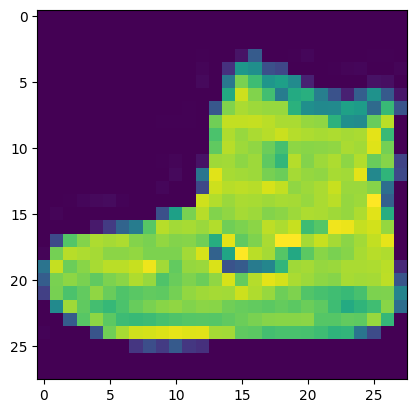

In [7]:
import matplotlib.pyplot as plt
print(f"image shape:{image.shape}")
plt.imshow(image.squeeze())

(-0.5, 27.5, 27.5, -0.5)

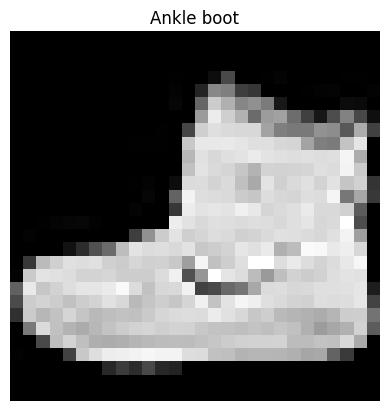

In [8]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

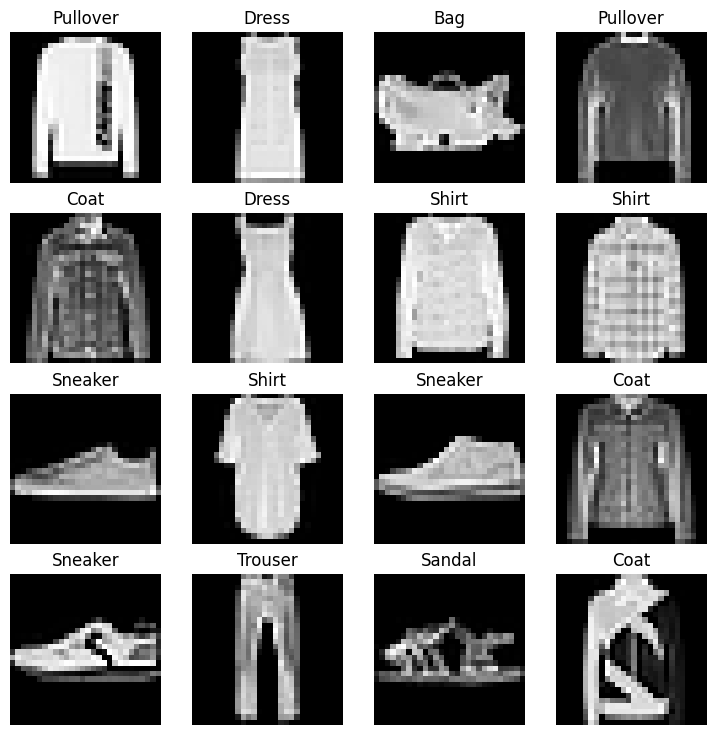

In [9]:
# Plot more image
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_inx = torch.randint(1, len(train_data), size=[1]).item()
  img, label = train_data[random_inx]
  plt.subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 2. Prepare DateLoader
Right now, our data is in the form of Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our dataset into batches or minibatches.

Why would we do that?

1. It is more computationally efficient, as in, your computing hardware may not be able to look at 60000 images in one hit. So we break it down to 32 image at a time (bitch size of 32)
2. It gives our neural network more chances to update its gradients per epoch



In [10]:
from torch.utils.data import DataLoader
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datesets into iterable(batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [11]:
# Take a look at what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader:{len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader:{len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7eddd4305360>, <torch.utils.data.dataloader.DataLoader object at 0x7eddd4306320>)
Length of train_dataloader:1875 batches of 32
Length of test_dataloader:313 batches of 32


In [12]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape,len(train_feature_batch)

(torch.Size([32, 1, 28, 28]), 32)

(-0.5, 27.5, 27.5, -0.5)

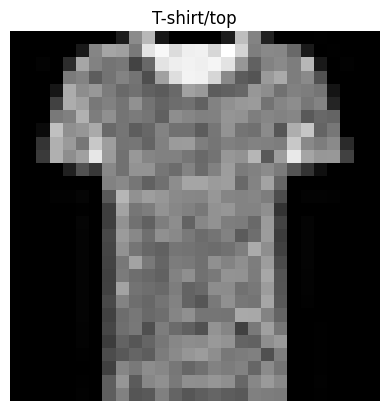

In [13]:
# show a sample
random_idx = torch.randint(0, len(train_feature_batch), size=[1])
img, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)


## 3. Model 0: Bulid a baseline model
When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a sample model you will try and improve upon with subsequent models

In other words: start simply and add complexity when necessary

In [14]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_feature_batch[0]

# Flatten the sample
output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [15]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_shape),
        nn.Linear(in_features=hidden_shape,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [16]:
# Setup the model with input parameter
model_0 = FashionMNISTModelV0(input_shape=784,
                              output_shape=len(class_names),
                              hidden_shape=10).to("cpu")

In [17]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 5.5346e-03, -1.1719e-02, -3.0173e-02,  ..., -2.2630e-02,
                        1.2981e-02, -2.6244e-02],
                      [ 1.9457e-02,  4.7735e-03,  1.5881e-02,  ...,  3.1012e-03,
                        3.3423e-02, -1.2228e-02],
                      [ 7.3337e-03, -7.8482e-04,  8.4703e-04,  ..., -1.0301e-02,
                       -8.7119e-03,  2.6998e-02],
                      ...,
                      [-1.8761e-02, -1.7956e-02, -1.5598e-02,  ...,  1.3421e-02,
                       -8.8616e-03,  8.4556e-03],
                      [-3.4946e-02, -2.3945e-02, -9.2499e-03,  ...,  1.5314e-02,
                       -2.5612e-02,  1.9367e-02],
                      [ 1.5549e-02, -7.5578e-03,  1.8854e-02,  ...,  1.4050e-06,
                       -1.3811e-02,  1.0797e-02]])),
             ('layer_stack.1.bias',
              tensor([-0.0148,  0.0080,  0.0021,  0.0114,  0.0273, -0.0003, -0.0268, -0.0323,
                

 ### 3.1 Setup the loss function, optimizer and the evaluation metrics
 * Loss function - `nn.CrossEntropyLoss()`
 * Optimizer - `torch.optim.SGD()`
 * eveluation metrics - we'll use accuracy as metrics

In [18]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("help_fucntion.py").is_file():
  print("help_function.py is exists, skipping download...")
else:
  print("Downloading ....")

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("help_functions.py", "wb") as f:
  f.write(request.content)


In [19]:
from help_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine Learning is very experimental.

Two of the main things you'll often to track are:

1. Model's performance(Loss function, accuracy, and etc.)
2. how fast it runs

In [20]:
from timeit import default_timer as timer
def print_train_timer(start:float,
                      end:float,
                      device:torch.device=None):
  """Print different between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time: 0.3f} seconds")
  return total_time

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epoches.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Lopp through testing batches, calculate the test loop *per batch*
4. Print out what's happening
5. Time it all

In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Creating training and test loop
for epoch in tqdm(range(epochs)):
  print(f"\nEpoch:{epoch}")

  ### Training
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    train_pred = model_0(X)
    # 2. Calculate loss
    loss = loss_fn(train_pred, y)
    train_loss += loss
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    if batch % 400 == 0:
      print(f"Look at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)
      # 2. Calculate Loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out what's happening each epoch
  print(f"Train Loss: {train_loss: .5f} | Test Loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_timer(start=train_time_start_on_cpu,
                                             end=train_time_end_on_cpu,
                                             device=str(next(model_0.parameters()).device))








  0%|          | 0/3 [00:00<?, ?it/s]


Epoch:0
Look at 0 / 60000 samples.
Look at 12800 / 60000 samples.
Look at 25600 / 60000 samples.
Look at 38400 / 60000 samples.
Look at 51200 / 60000 samples.
Train Loss:  0.58660 | Test Loss: 0.64144 | Test accuracy: 78.61

Epoch:1
Look at 0 / 60000 samples.
Look at 12800 / 60000 samples.
Look at 25600 / 60000 samples.
Look at 38400 / 60000 samples.
Look at 51200 / 60000 samples.
Train Loss:  0.47484 | Test Loss: 0.51570 | Test accuracy: 81.61

Epoch:2
Look at 0 / 60000 samples.
Look at 12800 / 60000 samples.
Look at 25600 / 60000 samples.
Look at 38400 / 60000 samples.
Look at 51200 / 60000 samples.
Train Loss:  0.45365 | Test Loss: 0.53136 | Test accuracy: 81.00
Train time on cpu:  27.106 seconds


In [22]:
test_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 4. Make predictions and get Model 0 results

In [23]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  """Return a dictionary containing the results of model predicting on data_loader"""
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"Model name": model.__class__.__name__,
          "Model loss": loss.numpy(),
          "Model accuracy": acc}

model_0_result = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)


## 5. Setup device agnostic-code to GPU

In [24]:
len(class_names)

10

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## 6. Model 1: Building a better model with non-linearity

In [26]:
# Create a model with non-linearity and linear layer
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape,
               output_shape,
               hidden_units):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),

    )
  def forward(self, x):
    return self.layer_stack(x)

# Create a instance of modelV1
model_1 = FashionMNISTModelV1(input_shape=784,
                              output_shape=len(class_names),
                              hidden_units=10).to(device)


In [27]:
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [28]:
from help_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops
Let's create a function loop:
* training loop - `test_step()`
* tesing loop - `test_step()`

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0,0
  for batch, (X, y) in enumerate(data_loader):
    model.train()
    # 0. Put the data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    train_pred = model(X)
    # 2. Calculate loss
    loss = loss_fn(train_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                            y_pred=train_pred.argmax(dim=1))
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()


  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss:{train_loss:.5f} | Train acc:{train_acc:.2f}")

In [30]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""

  test_loss, test_acc = 0, 0
  ###Testing
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_logits.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss:{test_loss:.5f} | Test accuracy: {test_acc:.2f}")





In [31]:

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evulaztion  loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device
             )
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,

            accuracy_fn=accuracy_fn,
            device=device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_timer(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
Train loss:0.70440 | Train acc:74.46
Test loss:0.55405 | Test accuracy: 80.79
Epoch:1
Train loss:0.50018 | Train acc:81.95
Test loss:0.47559 | Test accuracy: 82.75
Epoch:2
Train loss:0.46386 | Train acc:83.18
Test loss:0.49855 | Test accuracy: 82.82
Train time on cuda:  32.381 seconds


In [32]:
total_train_time_model_0

27.106363227000003

In [33]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device):
  """Return a dictionary containing the results of model predicting on data_loader"""
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"Model name": model.__class__.__name__,
          "Model loss": loss.item(),
          "Model accuracy": acc,
          "Device": device}


In [34]:
model_1_result = eval_model(model=model_1,
                           data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_1_result

{'Model name': 'FashionMNISTModelV1',
 'Model loss': 0.49854743480682373,
 'Model accuracy': 82.81749201277955,
 'Device': 'cuda'}

## Model 2: Building a convoluntional neural netork

In [35]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self,
               input_shape,
               output_shape,
               hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, #how big is the square that's going over the image?
                  stride=1, #default
                  padding=1), #options = "Valid"
         # output size = 28 * 28
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        # output size = 14 * 14
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # output size = 14 * 14
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units,3,padding=1),
        # output size = 14 * 14
        nn.ReLU(),
        nn.MaxPool2d(2)
        # output size = 7 * 7
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # The best way to get the in_features of output layer that is using code to help us
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.block_1(x)
    # Why should i print the output shape out?
    # look at the arguement of in_features of classifier
    #print(f"Output shape of conv_block_1:{x.shape}")
    x = self.block_2(x)
    #print(f"Output shape of conv_block_2:{x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier:{x.shape}")
    return x


In [36]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              output_shape=len(class_names),
                              hidden_units=10).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Stepping through `nn.Conv2d()`


In [37]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

In [38]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 64, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d()`

In [39]:
maxpool_layer = nn.MaxPool2d(kernel_size=2)
print(test_image.shape)
maxpool_output = maxpool_layer(conv_output)
print(maxpool_output.shape)
print(f"Test image original shape{test_image.shape}")
print(f"Test image shape with unsequeezed dimension:{test_image.unsqueeze(0).shape}")

torch.Size([3, 64, 64])
torch.Size([1, 64, 32, 32])
Test image original shapetorch.Size([3, 64, 64])
Test image shape with unsequeezed dimension:torch.Size([1, 3, 64, 64])


In [40]:
maxpool_output.unsqueeze(0).shape

torch.Size([1, 1, 64, 32, 32])

### 7.3 Setup a loss function and optimizer for `model_2`

In [41]:
from help_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [42]:
from timeit import default_timer as timer

model_2_train_start_on_gpu = timer()
# Setup the number of epoch
epochs = 3

for epoch in tqdm(range(epochs)):
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
            )

model_2_train_end_on_gpu = timer()
total_train_time_model_2 = print_train_timer(start=model_2_train_start_on_gpu,
                                    end=model_2_train_end_on_gpu,
                                    device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss:0.54252 | Train acc:80.86
Test loss:0.35267 | Test accuracy: 87.52
Train loss:0.34984 | Train acc:87.47
Test loss:0.32077 | Test accuracy: 88.28
Train loss:0.31464 | Train acc:88.57
Test loss:0.31045 | Test accuracy: 88.78
Train time on cuda:  63.825 seconds


In [43]:
next(model_2.parameters()).dtype

torch.float32

In [44]:
image= train_feature_batch[0]
image.dtype

torch.float32

In [45]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [46]:
# Get model_2 result
model_2_result = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)


In [47]:
model_2_result

{'Model name': 'FashionMNISTModelV2',
 'Model loss': 0.3466227352619171,
 'Model accuracy': 87.38019169329074,
 'Device': 'cuda'}

In [48]:
## 8. Compare model results and training time

In [49]:
import pandas as pd
compare_model = pd.DataFrame([model_0_result,
                             model_1_result,
                             model_2_result])


In [50]:
compare_model

,Model name,Model loss,Model accuracy,Device
0,FashionMNISTModelV0,0.5313585,81.000399,NaN
1,FashionMNISTModelV1,0.498547,82.817492,cuda
2,FashionMNISTModelV2,0.346623,87.380192,cuda


In [51]:
# Add training time to results comparison
compare_model["Training time"] = [total_train_time_model_0,
                                  total_train_time_model_1,
                                  total_train_time_model_2]

In [52]:
compare_model

,Model name,Model loss,Model accuracy,Device,Training time
0,FashionMNISTModelV0,0.5313585,81.000399,NaN,27.106363
1,FashionMNISTModelV1,0.498547,82.817492,cuda,32.380660
2,FashionMNISTModelV2,0.346623,87.380192,cuda,63.825385


## 9. Make and evaluate random predictions with best model

In [53]:
 def make_predictions(model:torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pre_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)
      # Forward pass(model outputs raw logits)
      pre_logit = model(sample)
      # Get the probability
      pre_prob = torch.softmax(pre_logit.squeeze(),dim=0)
      #
      pre_probs.append(pre_prob.cpu())
  return torch.stack(pre_probs)


In [54]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k =9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape


torch.Size([1, 28, 28])

In [55]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities
pred_probs.shape

torch.Size([9, 10])

In [56]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

In [57]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

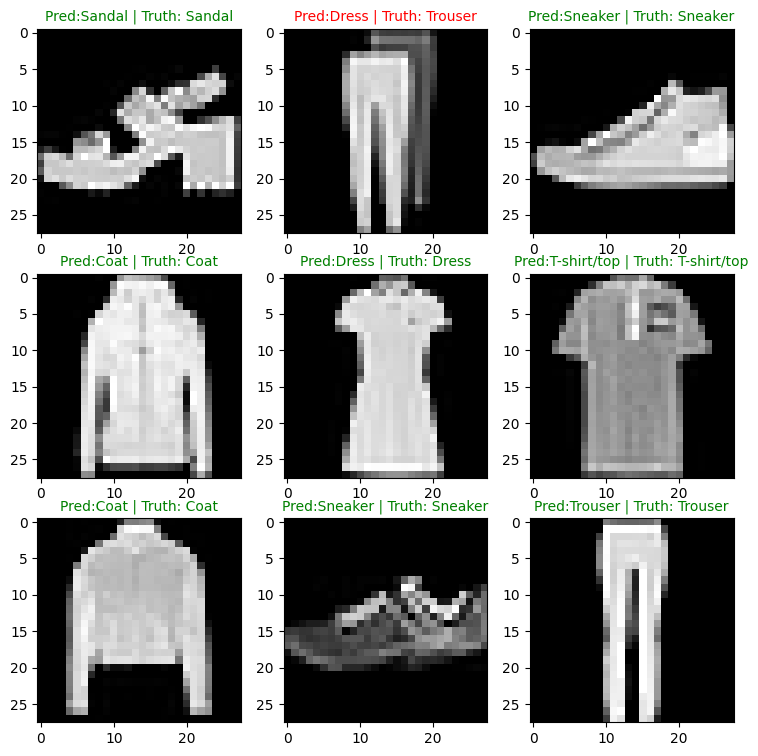

In [58]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subpolt
  plt.subplot(nrows, ncols, i+1)
  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")
  # Find the prediction (show the label)
  pred_label = class_names[pred_classes[i]]
  # Get the truth label
  truth_label = class_names[test_labels[i]]
  # Create a tittle for the plot
  title_text = f"Pred:{pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title test
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

## 10. Making a confusion martrix for further prediction evaluation

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion martrix using`mlxtend.plotting.plot_confusionMatrix`

In [59]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Marking predictions"):
    # Send the data to our target model
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logits = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list into a tensor
y_preds_tensor = torch.cat(y_preds)

Marking predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [60]:
# see if torchmetrics exist, if not, install it
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
mlxtend version: 0.23.1


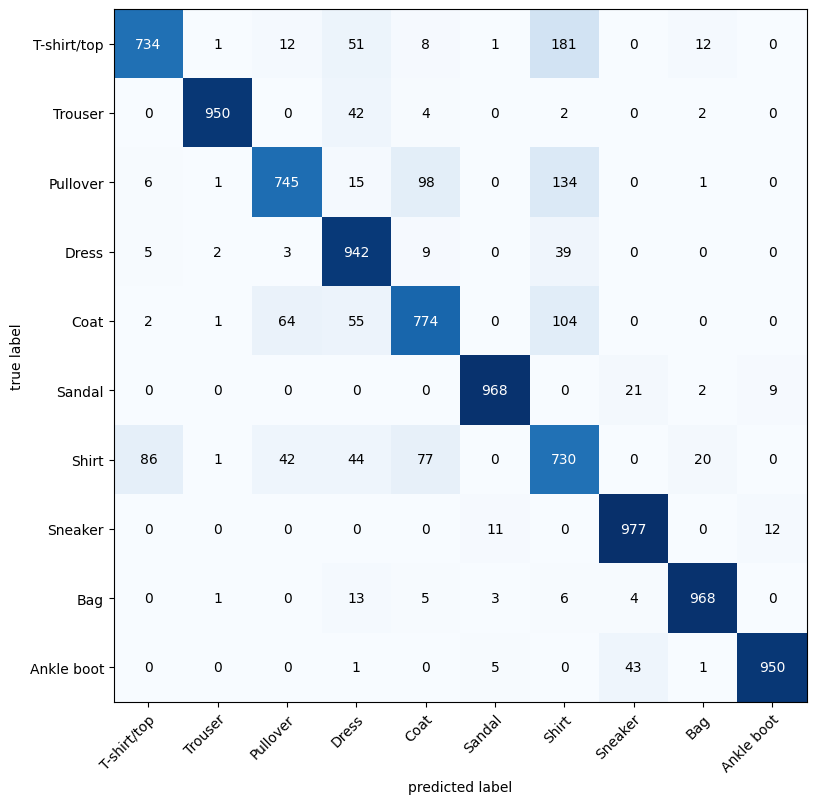

In [61]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with Numpy
    class_names=class_names,
    figsize=(10,9)
)

## 11. Save and load best performing model


In [63]:
from pathlib import Path


# Create model dictory path
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "03_Pytorch_computer_vision.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to:{MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to:model/03_Pytorch_computer_vision.pth


In [67]:
# Create a new instance
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [71]:
# Evluate loaded model
loaded_model_2_result = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)


In [68]:
model_2_result

{'Model name': 'FashionMNISTModelV2',
 'Model loss': 0.3466227352619171,
 'Model accuracy': 87.38019169329074,
 'Device': 'cuda'}

In [72]:
loaded_model_2_result

{'Model name': 'FashionMNISTModelV2',
 'Model loss': 0.3466227352619171,
 'Model accuracy': 87.38019169329074,
 'Device': 'cuda'}

In [73]:
torch.isclose(torch.tensor(model_2_result["Model loss"]),
              torch.tensor(loaded_model_2_result["Model loss"]))

tensor(True)